# Big Data Analytics Project

Data Mining, Text Mining and Big Data Analytics

Vorabbi Sara - 0001026226 - sara.vorabbi@gmail.com

In this notebook we explore the [Covertype Dataset](https://archive.ics.uci.edu/dataset/31/covertype) from UC Irvine Machine Learning Repository. We proceed by exploring the dataset, preprocessing it and training three Machine Learning algorithm on it.



In this project we see the application of the PySpark framework, the Python API for Apache Spark. We see what can be achieved throught it and the limitations of the models.

This project was implemented using a Colab Notebook.

## Import file in Colab

In [1]:
# import the dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We copy the db in the current working folder `./`

In [2]:
!cp "/content/drive/MyDrive/DB_BDA/covtype.data.gz" ./

## Import the dataset with PySpark

We install the PySpark package and we proceed to import all the modules and classes we need for the project.

In [69]:
!pip install pyspark
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.3
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.25
Branch HEAD
Compiled by user haejoon.lee on 2024-09-09T05:20:05Z
Revision 32232e9ed33bb16b93ad58cfde8b82e0f07c0970
Url https://github.com/apache/spark
Type --help for more information.


In [70]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType
from pyspark.sql.functions import col, sum as _sum, when

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes, LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

We proceed with the creation of a Spark session and with the configuration of some parameters in order to control the behaviour reguarding resourses allocation and to improve the performance.

```
spark.driver.memory", "8g"
spark.executor.memory", "8g"
spark.executor.instances", "4"
spark.executor.cores", "2"
spark.sql.shuffle.partitions", "300"

SISTEMA LA CONFIGURATION DOCUMENTATION
https://spark.apache.org/docs/latest/configuration.html
```

Whithout these settings the training of the ML algorithms could not end because of an OOM error. Using this configurations the training managed to finish successfully.

In [72]:
# create a Spark session
spark = SparkSession.builder \
    .appName("BDA_Project") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "2") \
    .config("spark.sql.shuffle.partitions", "300") \
    .getOrCreate()

In [73]:
file_path = "/content/covtype.data.gz"

The dataset does not contain a header, so it is best to add a schema to the dataframe with `StructType` using the information from the documentation of the Covertype dataset.



In [74]:
schema = StructType([
    StructField("Elevation", IntegerType(), True),
    StructField("Aspect", IntegerType(), True),
    StructField("Slope", IntegerType(), True),
    StructField("Horizontal_Distance_To_Hydrology", IntegerType(), True),
    StructField("Vertical_Distance_To_Hydrology", IntegerType(), True),
    StructField("Horizontal_Distance_To_Roadways", IntegerType(), True),
    StructField("Hillshade_9am", IntegerType(), True),
    StructField("Hillshade_Noon", IntegerType(), True),
    StructField("Hillshade_3pm", IntegerType(), True),
    StructField("Horizontal_Distance_To_Fire_Points", IntegerType(), True),
    StructField("Wilderness_Area1", IntegerType(), True),
    StructField("Wilderness_Area2", IntegerType(), True),
    StructField("Wilderness_Area3", IntegerType(), True),
    StructField("Wilderness_Area4", IntegerType(), True),
    StructField("Soil_Type1", IntegerType(), True),
    StructField("Soil_Type2", IntegerType(), True),
    StructField("Soil_Type3", IntegerType(), True),
    StructField("Soil_Type4", IntegerType(), True),
    StructField("Soil_Type5", IntegerType(), True),
    StructField("Soil_Type6", IntegerType(), True),
    StructField("Soil_Type7", IntegerType(), True),
    StructField("Soil_Type8", IntegerType(), True),
    StructField("Soil_Type9", IntegerType(), True),
    StructField("Soil_Type10", IntegerType(), True),
    StructField("Soil_Type11", IntegerType(), True),
    StructField("Soil_Type12", IntegerType(), True),
    StructField("Soil_Type13", IntegerType(), True),
    StructField("Soil_Type14", IntegerType(), True),
    StructField("Soil_Type15", IntegerType(), True),
    StructField("Soil_Type16", IntegerType(), True),
    StructField("Soil_Type17", IntegerType(), True),
    StructField("Soil_Type18", IntegerType(), True),
    StructField("Soil_Type19", IntegerType(), True),
    StructField("Soil_Type20", IntegerType(), True),
    StructField("Soil_Type21", IntegerType(), True),
    StructField("Soil_Type22", IntegerType(), True),
    StructField("Soil_Type23", IntegerType(), True),
    StructField("Soil_Type24", IntegerType(), True),
    StructField("Soil_Type25", IntegerType(), True),
    StructField("Soil_Type26", IntegerType(), True),
    StructField("Soil_Type27", IntegerType(), True),
    StructField("Soil_Type28", IntegerType(), True),
    StructField("Soil_Type29", IntegerType(), True),
    StructField("Soil_Type30", IntegerType(), True),
    StructField("Soil_Type31", IntegerType(), True),
    StructField("Soil_Type32", IntegerType(), True),
    StructField("Soil_Type33", IntegerType(), True),
    StructField("Soil_Type34", IntegerType(), True),
    StructField("Soil_Type35", IntegerType(), True),
    StructField("Soil_Type36", IntegerType(), True),
    StructField("Soil_Type37", IntegerType(), True),
    StructField("Soil_Type38", IntegerType(), True),
    StructField("Soil_Type39", IntegerType(), True),
    StructField("Soil_Type40", IntegerType(), True),
    StructField("Cover_Type", IntegerType(), True),
])

This is how the dataset present itself.

In [75]:
df = spark.read.csv(file_path, header=False, schema=schema)
df.show()

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wilderness_Area3|Wi

From the documentation we have a clear understanding of what each features represents.

```
Name                                    Data Type       Measurement                  Description

Elevation                               quantitative    meters                       Elevation in meters
Aspect                                  quantitative    azimuth                      Aspect in degrees azimuth
Slope                                   quantitative    degrees                      Slope in degrees
Horizontal_Distance_To_Hydrology        quantitative    meters                       Horz Dist to nearest surface water features
Vertical_Distance_To_Hydrology          quantitative    meters                       Vert Dist to nearest surface water features
Horizontal_Distance_To_Roadways         quantitative    meters                       Horz Dist to nearest roadway
Hillshade_9am                           quantitative    0 to 255 index               Hillshade index at 9am, summer solstice
Hillshade_Noon                          quantitative    0 to 255 index               Hillshade index at noon, summer soltice
Hillshade_3pm                           quantitative    0 to 255 index               Hillshade index at 3pm, summer solstice
Horizontal_Distance_To_Fire_Points      quantitative    meters                       Horz Dist to nearest wildfire ignition points
Wilderness_Area (4 binary columns)      qualitative     0 (absence) or 1 (presence)  Wilderness area designation
Soil_Type (40 binary columns)           qualitative     0 (absence) or 1 (presence)  Soil Type designation
Cover_Type (7 types)                    integer         1 to 7                       Forest Cover Type designation
```



## Dataset exploration

In this section we explore the dataset since we want to have a general sense of what is contained in it and the possible distribution of the data.

In [ ]:
num_rows = df.count()
num_columns = len(df.columns)

print(f"The dataframe has {num_rows} rows and {num_columns} columns.")

The dataframe has 581012 rows and 55 columns.


We print a summary of the statistics of the features of the dataframe, including count, mean, standard deviation, min, and max.

In [ ]:
df.describe().show()

+-------+-----------------+------------------+------------------+--------------------------------+------------------------------+-------------------------------+------------------+------------------+------------------+----------------------------------+-------------------+--------------------+------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------

We want to check the distribution of target class values `Cover_Type`.

In [ ]:
df.groupBy("Cover_Type").count().orderBy("count").show()

+----------+------+
|Cover_Type| count|
+----------+------+
|         4|  2747|
|         5|  9493|
|         6| 17367|
|         7| 20510|
|         3| 35754|
|         1|211840|
|         2|283301|
+----------+------+



It is clear that classes 1 and 2 are predominant, while classes 4 and 5 have fewer samples. This means a significant imbalance is present that could impact the training of the models, since they could become biased towards the predominant classes.

We also check that the classification class `Cover_type` has no null entry, as specified in the documentation.

In [ ]:
df.filter(df.Cover_Type.isNull()).show()

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wilderness_Area3|Wi

We proceed to trace histogramms for each feature (excluding wilderness areas and soil types) to check the distrubution of the data.

In [ ]:
df_pandas = df.toPandas()

<ipython-input-95-e886526529fe>:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


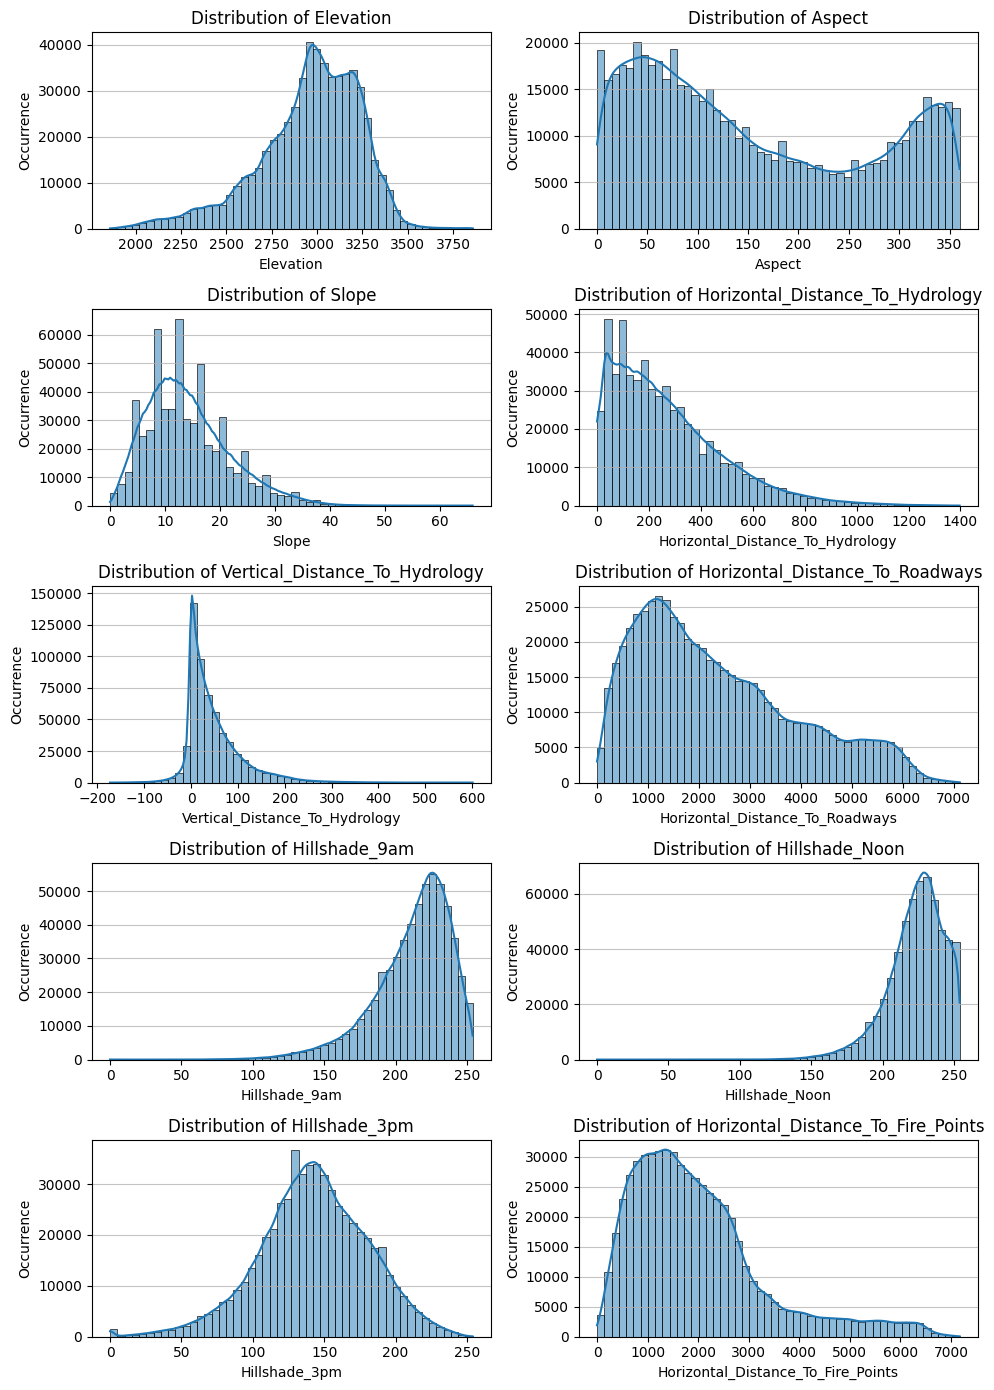

In [95]:
features = df.columns[:10]

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 14), layout='constrained')

axs = axs.flatten()

for i, col in enumerate(features):

    sns.histplot(df_pandas[col], kde=True, bins=50, ax=axs[i])

    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Occurrence')
    axs[i].grid(axis='y', alpha=0.75)

plt.tight_layout()

plt.show()

<ipython-input-118-f8b855249459>:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


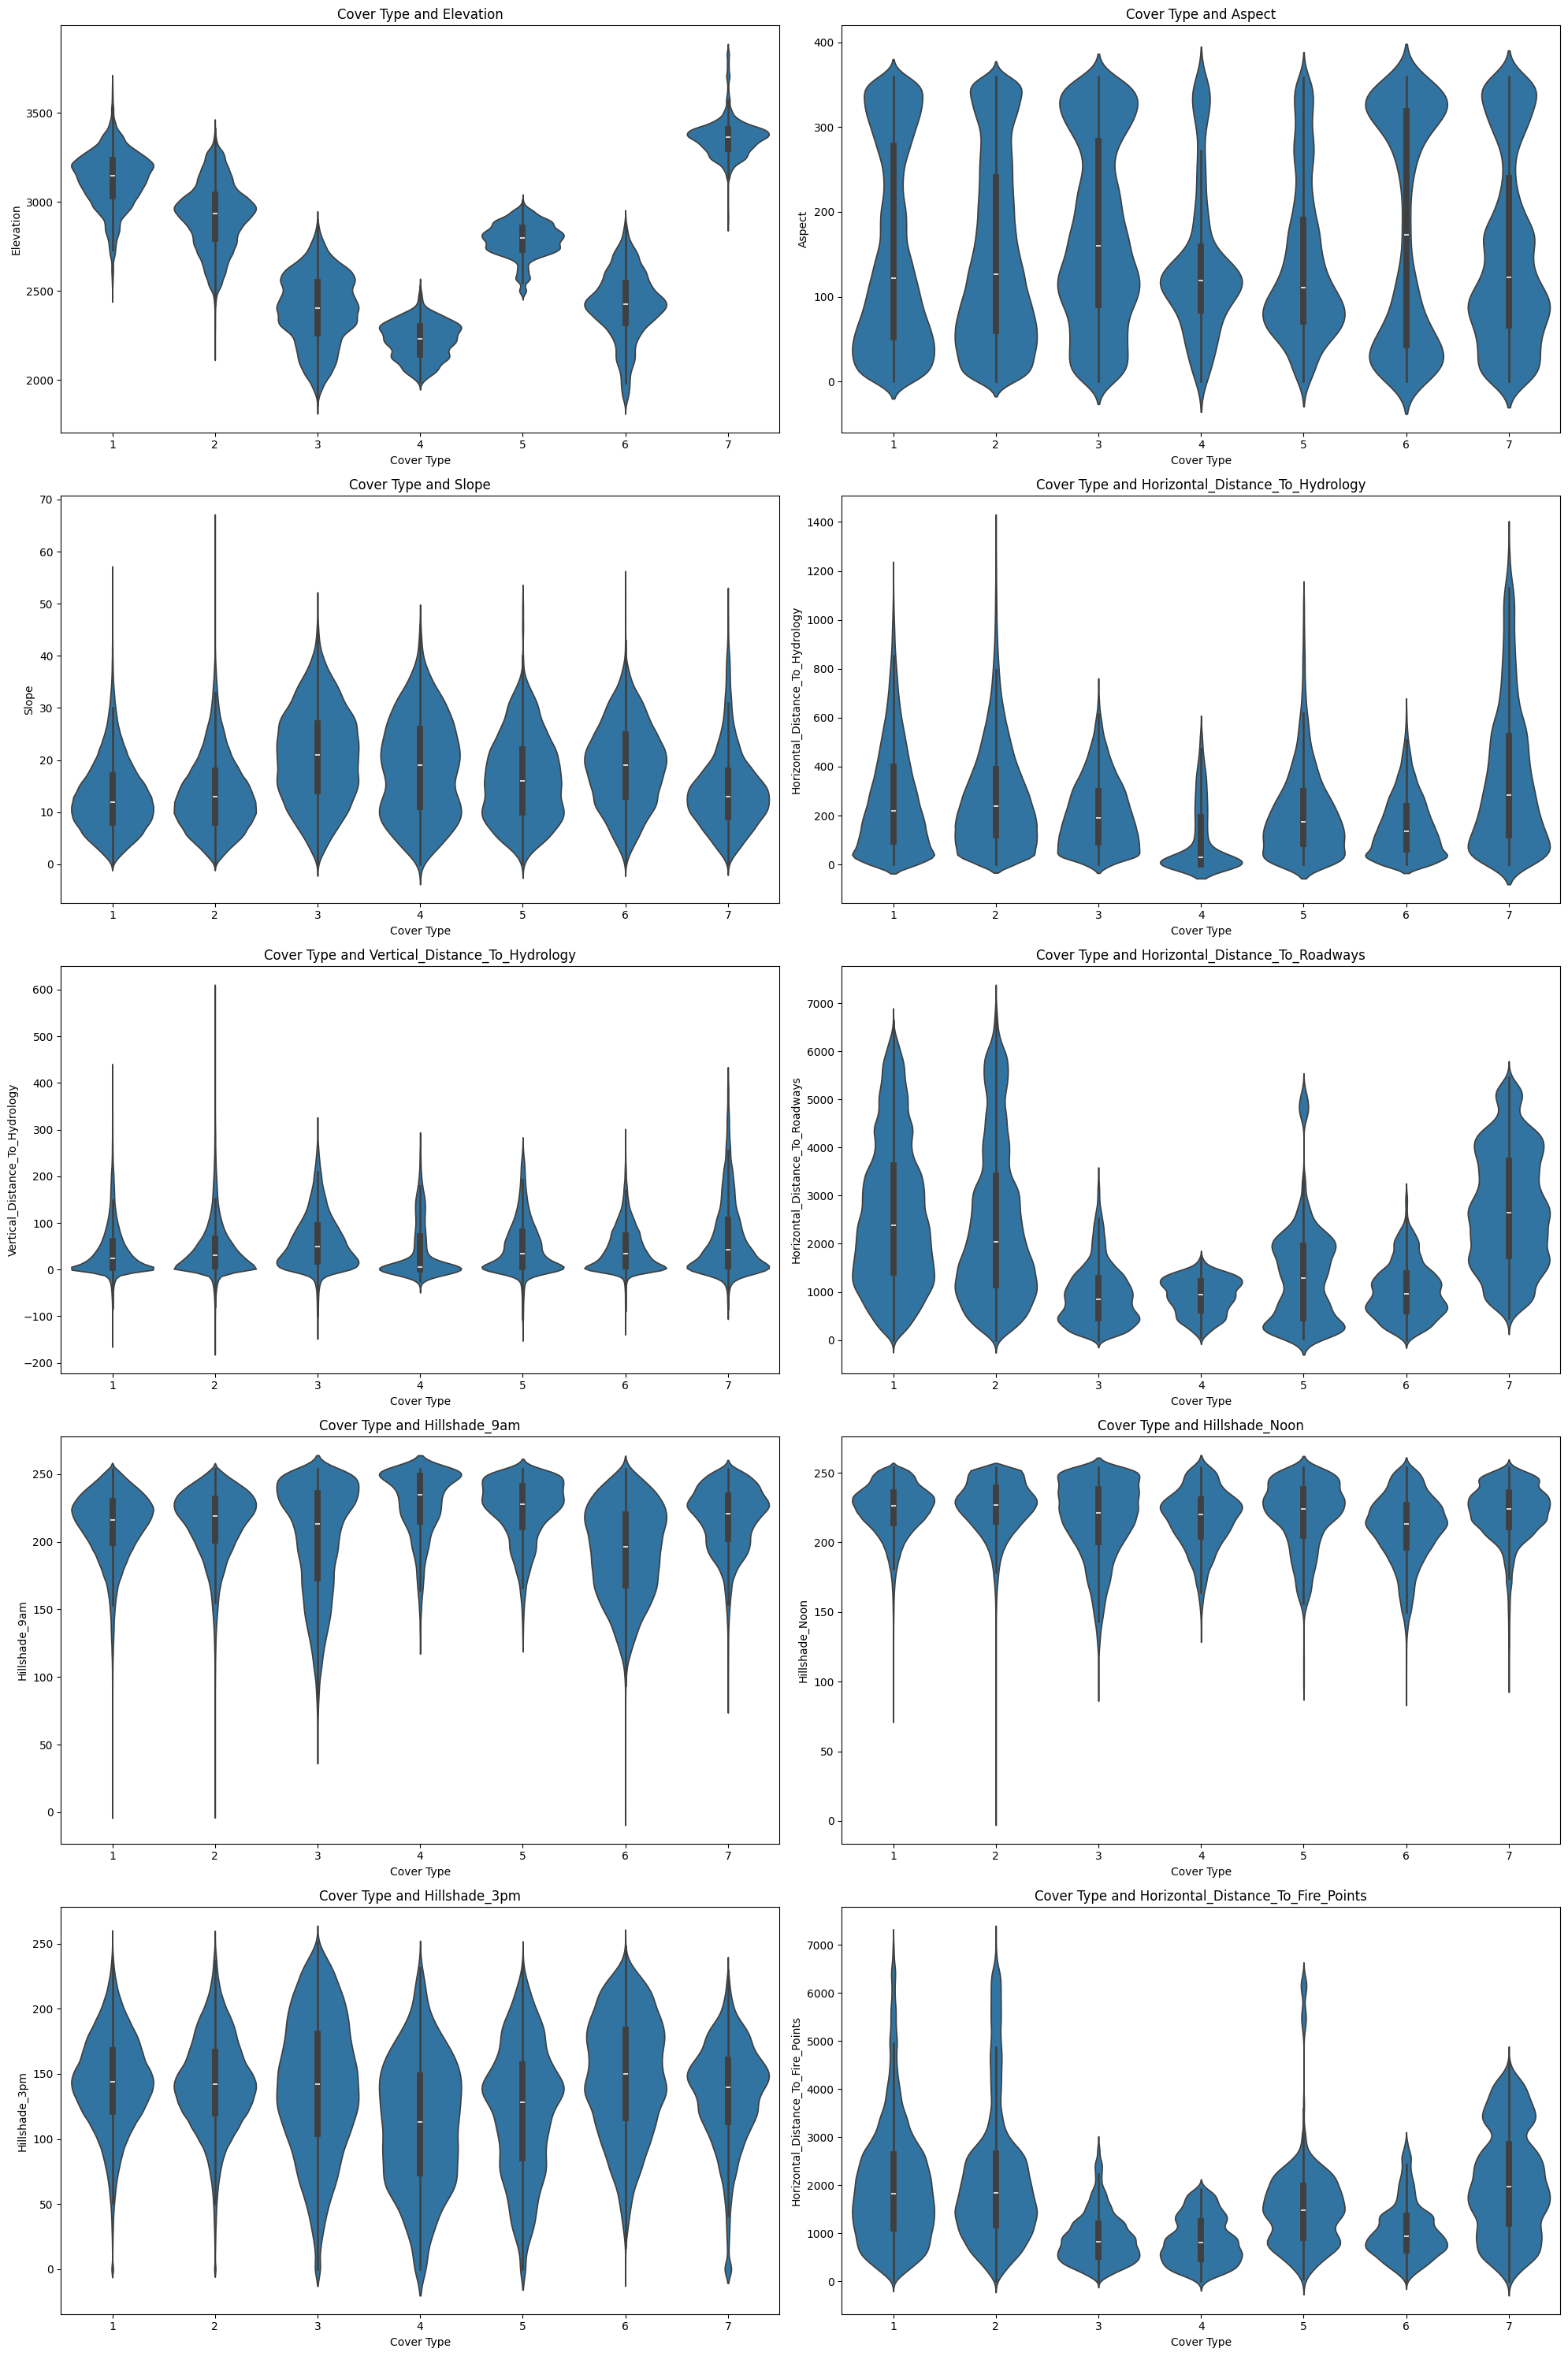

In [118]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 30), layout='constrained')
#    plt.figure(figsize=(12, 6))

axs = axs.flatten()

for i, col in enumerate(features):

    #sns.countplot(data=df_pandas[["Cover_Type", f"{col}"]], x="Cover_Type", hue=f"{col}", palette="viridis")
    sns.violinplot(x="Cover_Type", y=f"{col}", data=df_pandas, density_norm='width', ax=axs[i])

    axs[i].set_title(f"Cover Type and {col}")
    axs[i].set_xlabel("Cover Type")
    axs[i].set_ylabel(f"{col}")

plt.tight_layout()
plt.show()

<ipython-input-114-049862da2dcc>:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


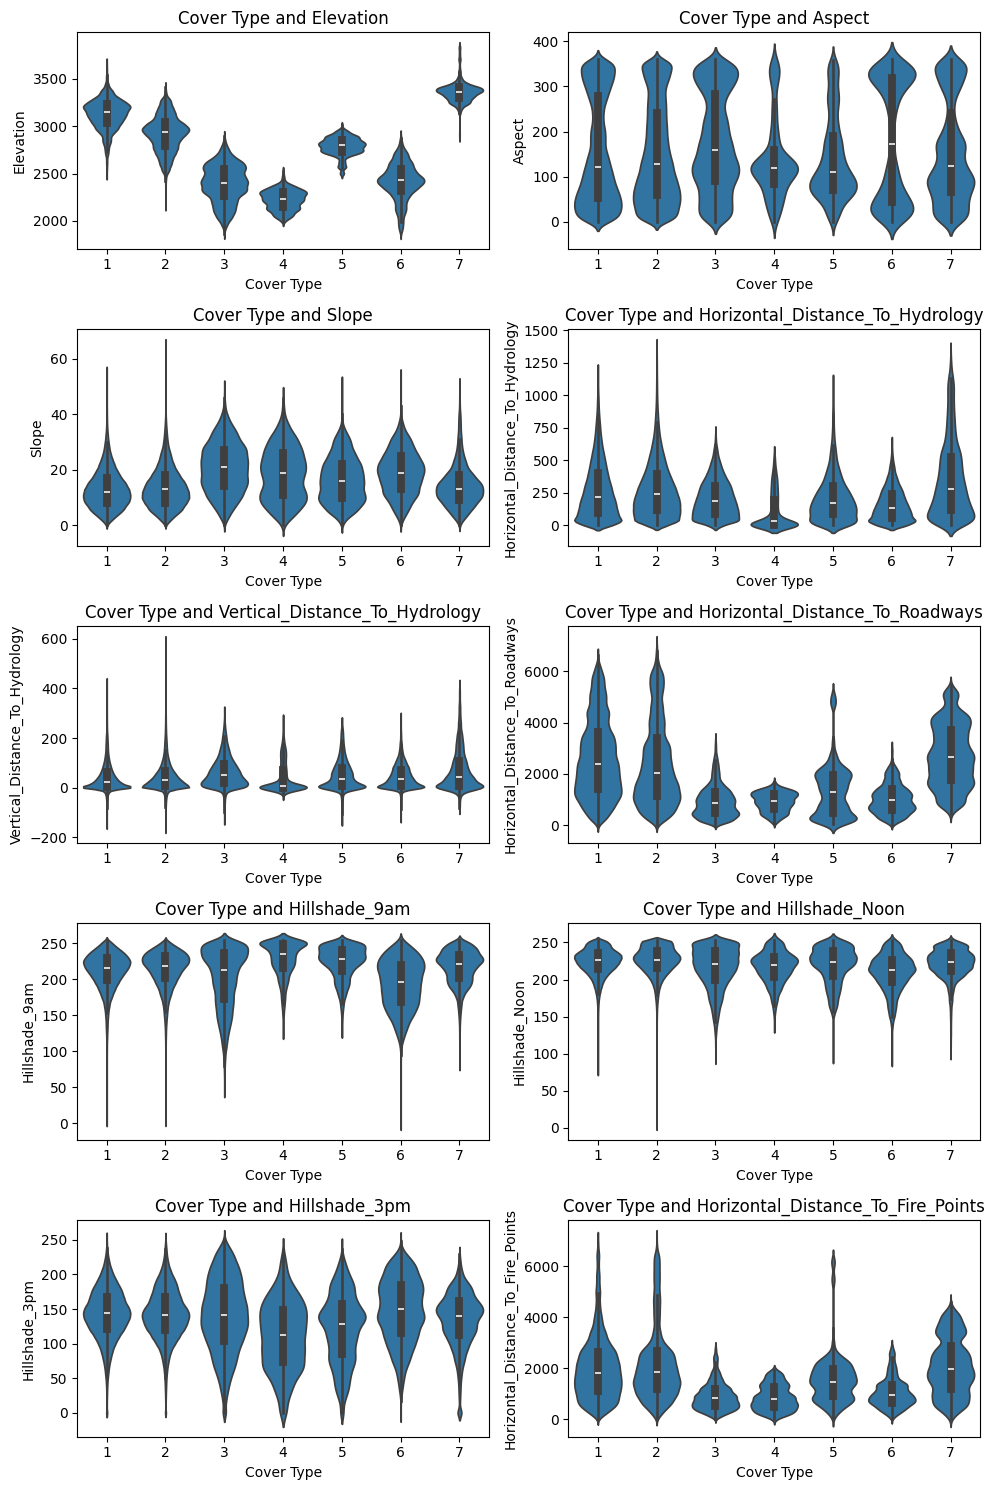

In [114]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 15), layout='constrained')
#    plt.figure(figsize=(12, 6))

axs = axs.flatten()

for i, col in enumerate(features):

    #sns.countplot(data=df_pandas[["Cover_Type", f"{col}"]], x="Cover_Type", hue=f"{col}", palette="viridis")
    sns.violinplot(x="Cover_Type", y=f"{col}", data=df_pandas, density_norm='width', ax=axs[i])

    axs[i].set_title(f"Cover Type and {col}")
    axs[i].set_xlabel("Cover Type")
    axs[i].set_ylabel(f"{col}")

plt.tight_layout()
plt.show()

<ipython-input-117-bdf629bbed78>:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


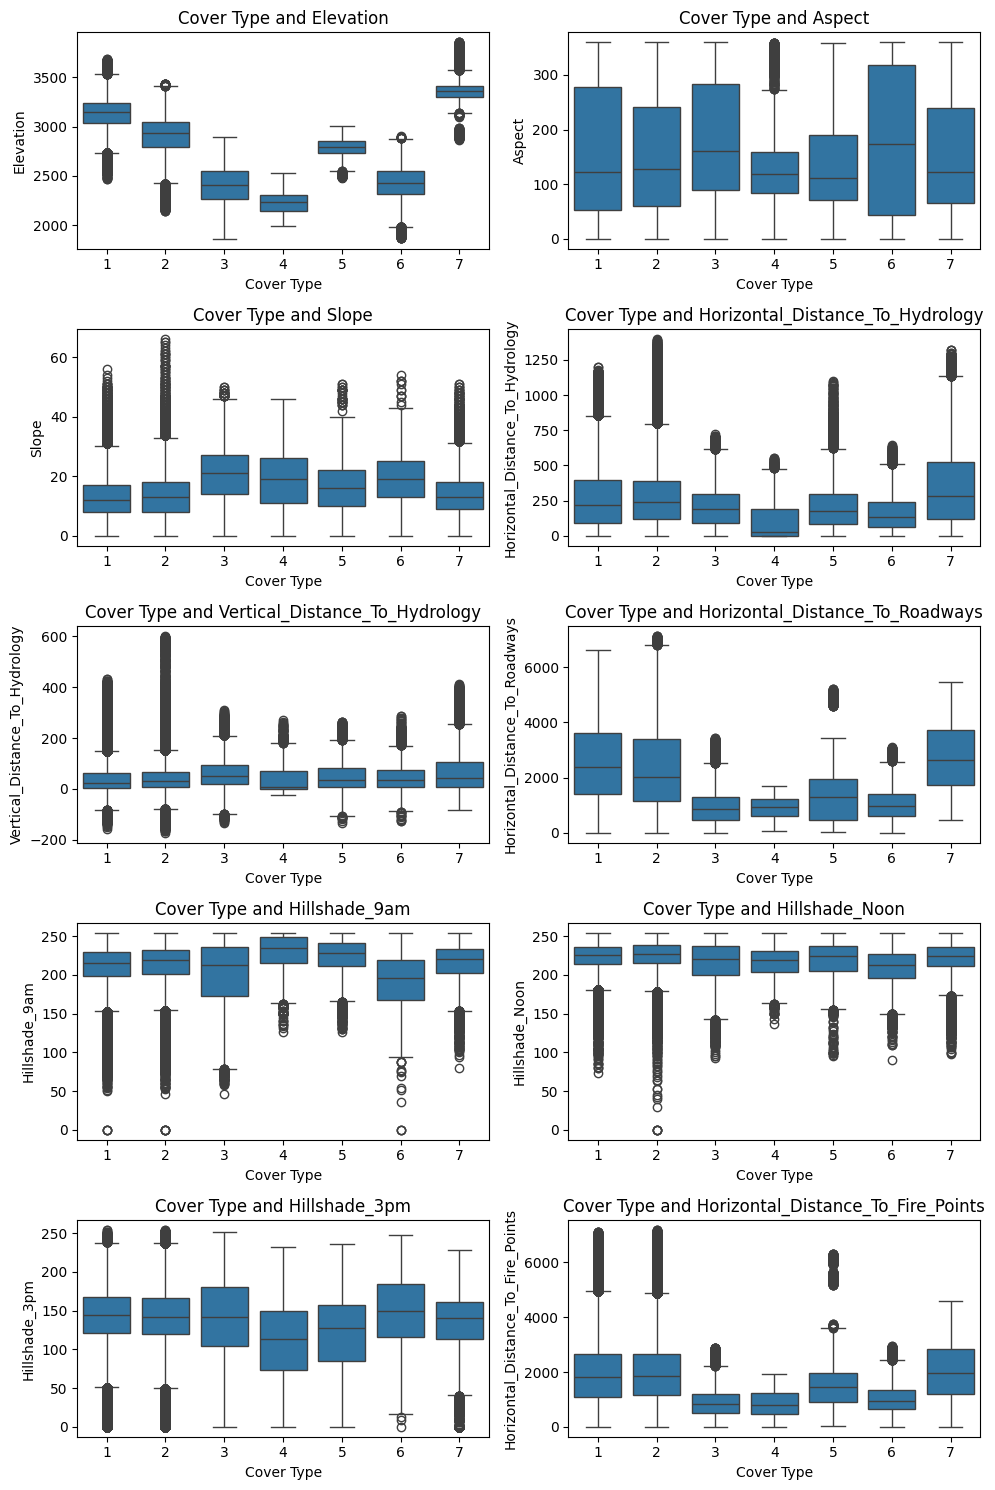

In [117]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 15), layout='constrained')
#    plt.figure(figsize=(12, 6))

axs = axs.flatten()

for i, col in enumerate(features):

    #sns.violinplot(x="Cover_Type", y=f"{col}", data=df_pandas, density_norm='width', ax=axs[i])
    sns.boxplot(x="Cover_Type", y=f"{col}", data=df_pandas, ax=axs[i])

    axs[i].set_title(f"Cover Type and {col}")
    axs[i].set_xlabel("Cover Type")
    axs[i].set_ylabel(f"{col}")

plt.tight_layout()
plt.show()

### Wilderness areas

From the documentation we know that each observation (entry of the db) was collected in one of the 4 wilderness areas located in the Roosevelt National Forest of Northern Colorado. The region are the following:
*   Area 1: Rawah
*   Area 2: Neota
*   Area 3: Comanche Peak
*   Area 4: Cache la Poudre




We can see how each entry of the db correspond to one of the 4 wilderness area.





In [ ]:
# check wilderness area is one hot encoding

We also know that in each Wilderness Area are present various type of Cover Type, our target class:


**Wilderness Area 1** (Rawah) - **Wilderness Area 3** (Comanche Peak)
*  Cover Type 2 - Lodgepole
*  Cover Type 1 - Spruce/Fir
*  Cover Type 5 - Aspen

**Wilderness Area 2** (Neota)

*  Cover Type 1 - Spruce/Fir

**Wilderness Area 4** (Cache la Poudre)

*  Cover Type 3 - Ponderosa pine
*  Cover Type 6 - Douglas-fir
*  Cover Type 4 - Cottonwood/willow

We want to check if this is accurate. For each `wilderness_area` we check how many `cover_type` are there.

In [ ]:
wilderness_areas = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']

In [ ]:
for wild_area in wilderness_areas:
    print(f"Cover Type distrinution for {wild_area}:")
    df.groupBy("Cover_Type", wild_area).count().filter(f"{wild_area} = 1").orderBy(col("count").desc()).show()

Cover Type distrinution for Wilderness_Area1:
+----------+----------------+------+
|Cover_Type|Wilderness_Area1| count|
+----------+----------------+------+
|         2|               1|146197|
|         1|               1|105717|
|         7|               1|  5101|
|         5|               1|  3781|
+----------+----------------+------+

Cover Type distrinution for Wilderness_Area2:
+----------+----------------+-----+
|Cover_Type|Wilderness_Area2|count|
+----------+----------------+-----+
|         1|               1|18595|
|         2|               1| 8985|
|         7|               1| 2304|
+----------+----------------+-----+

Cover Type distrinution for Wilderness_Area3:
+----------+----------------+------+
|Cover_Type|Wilderness_Area3| count|
+----------+----------------+------+
|         2|               1|125093|
|         1|               1| 87528|
|         3|               1| 14300|
|         7|               1| 13105|
|         6|               1|  7626|
|         5|    

From the output we see that the documentation was partially accurate. The presence of some cover types was undestimated like the presence of Cover Type 2 (Lodgepole) in Wildernaess Area 4 or Cover Type 3 and 7 in Wildernaess Area 3

Both Wildernaess Area 1 and 3 present a predominance of Cover Type 2 (Lodgepole)
and 1 (Spruce/Fir). This might suggest that these areas may share similar environmental conditions, such as elevation or soil type.

Wilderness area 3 have a broader distributions of multiple cover types meaning that the environmental conditions may vary more. Insteas Wilderness area 2 has more specific ecological zones.


### Check for the soil

Now we check the soil type features and we see the occurrencies of them.

In [ ]:
soil_type_features = [col for col in df.columns if col.startswith("Soil_Type")]

df_soil_check = df.withColumn("Soil_Type_Sum", sum(col(c) for c in soil_type_features))

invalid_soil_rows = df_soil_check.filter(col("Soil_Type_Sum") != 1)

invalid_count = invalid_soil_rows.count()

In [ ]:
if invalid_count == 0:
    print("All rows have exactly one Soil_Type set to 1.")
else:
    print(f"There are {invalid_count} rows with invalid Soil_Type combinations.")
    invalid_soil_rows.show(truncate=False)

All rows have exactly one Soil_Type set to 1.


This check conferm us that the soil type is a one hot encoding. We now proceed to show the occurrence of the soil type features.

In [76]:
df_pandas = df.toPandas()

In [ ]:
soil_type_counts = df_pandas.iloc[:, 14:54].sum().reset_index()
soil_type_counts.columns = ['Soil_Type', 'Count']

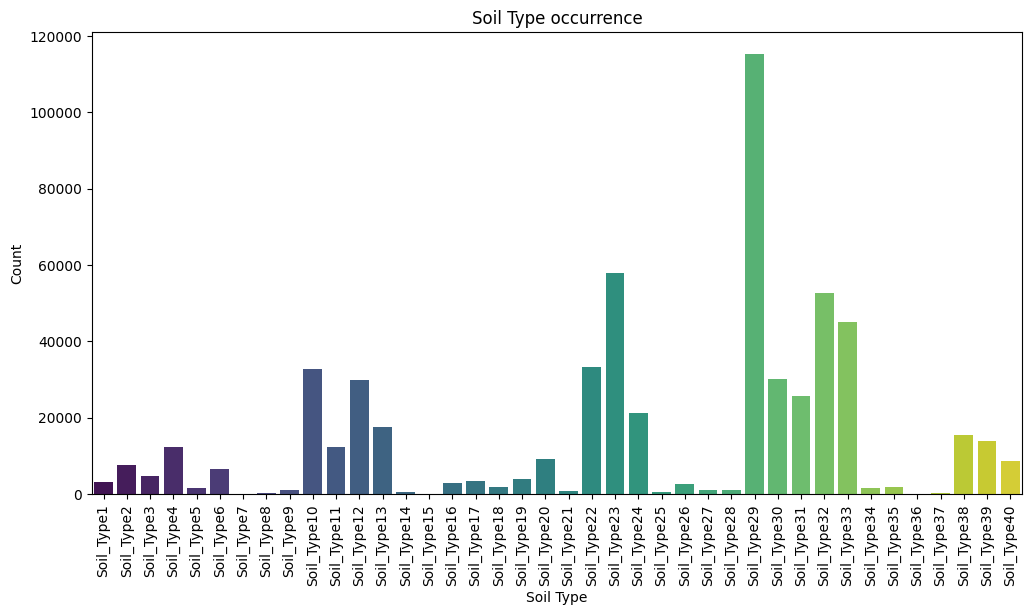

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Soil_Type', y='Count', hue='Soil_Type', data=soil_type_counts, palette='viridis')
plt.xticks(rotation=90)
plt.title('Soil Type occurrence')
plt.xlabel('Soil Type')
plt.ylabel('Count')
plt.show()

In [ ]:
soil_type_features


for soil in soil_type_features:
    print(f"Cover Type distrinution for {soil}:")
    df.groupBy("Cover_Type", soil).count().filter(f"{soil} = 1").orderBy(col("count").desc()).show()

Cover Type distrinution for Soil_Type1:
+----------+----------+-----+
|Cover_Type|Soil_Type1|count|
+----------+----------+-----+
|         3|         1| 2101|
|         6|         1|  752|
|         4|         1|  178|
+----------+----------+-----+

Cover Type distrinution for Soil_Type2:
+----------+----------+-----+
|Cover_Type|Soil_Type2|count|
+----------+----------+-----+
|         3|         1| 4991|
|         6|         1| 1303|
|         2|         1|  852|
|         5|         1|  264|
|         4|         1|  115|
+----------+----------+-----+

Cover Type distrinution for Soil_Type3:
+----------+----------+-----+
|Cover_Type|Soil_Type3|count|
+----------+----------+-----+
|         3|         1| 2411|
|         2|         1| 1191|
|         4|         1| 1018|
|         6|         1|  203|
+----------+----------+-----+

Cover Type distrinution for Soil_Type4:
+----------+----------+-----+
|Cover_Type|Soil_Type4|count|
+----------+----------+-----+
|         3|         1| 750

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_analysis, x="Cover_Type", hue="Wilderness_Area", palette="viridis")
plt.title(f"Relationship Between Cover Type and Wilderness_Area")
plt.xlabel("Cover Type")
plt.ylabel("count")
plt.legend(title="Wilderness Areas")
plt.show()

### ALTRE PROVE????

In [ ]:
df_analysis = df.withColumn(
    "Wilderness_Area",
    when(col("Wilderness_Area1") == 1, 1)
    .when(col("Wilderness_Area2") == 1, 2)
    .when(col("Wilderness_Area3") == 1, 3)
    .when(col("Wilderness_Area4") == 1, 4)
)

df_analysis = df_analysis.select("Wilderness_Area", "Cover_Type")
df_analysis = df_analysis.toPandas()

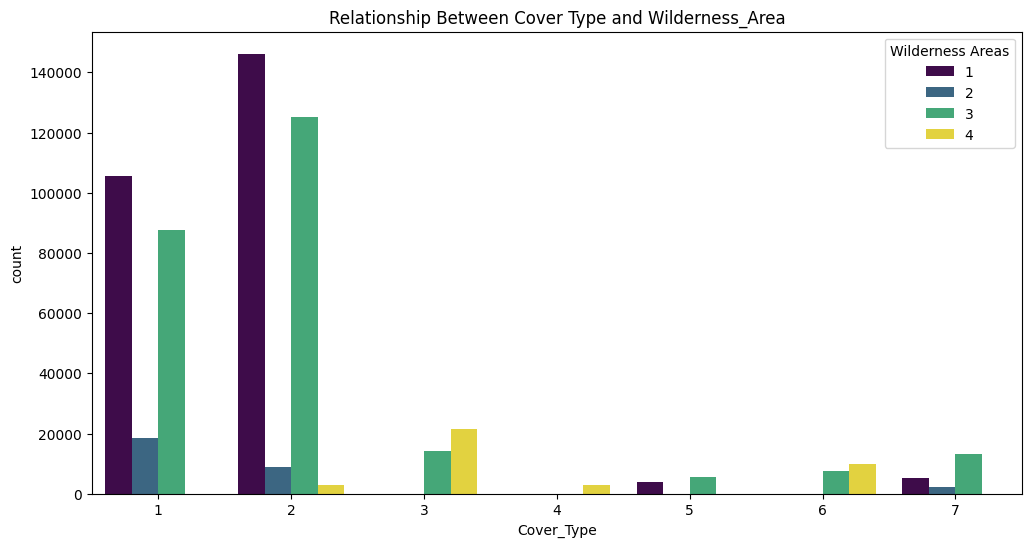

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_analysis, x="Cover_Type", hue="Wilderness_Area", palette="viridis")
plt.title(f"Relationship Between Cover Type and Wilderness_Area")
plt.xlabel("Cover Type")
plt.ylabel("count")
plt.legend(title="Wilderness Areas")
plt.show()

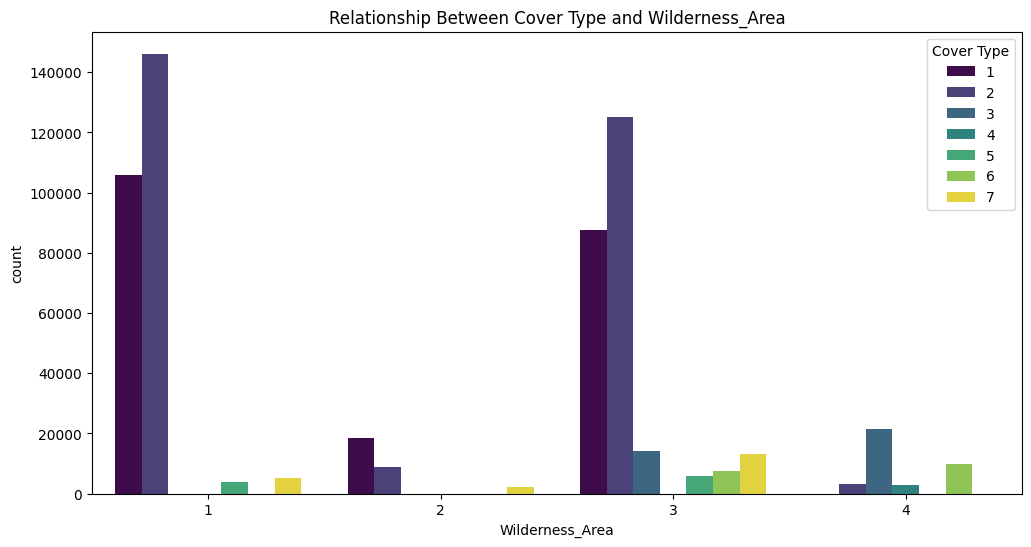

In [ ]:
plt.figure(figsize=(12, 6))
#sns.histplot(x="Wilderness_Area", y="Cover_Type", data=df_analysis)
#sns.violinplot(x="Cover_Type", y="Wilderness_Area", data=df_analysis)
#sns.boxplot(x="Wilderness_Area", y="Cover_Type", data=df_analysis)
sns.countplot(data=df_analysis, x="Wilderness_Area", hue="Cover_Type", palette="viridis")
plt.title(f"Relationship Between Cover Type and Wilderness_Area")
plt.xlabel("Wilderness_Area")
plt.ylabel("count")
plt.legend(title="Cover Type")
plt.show()

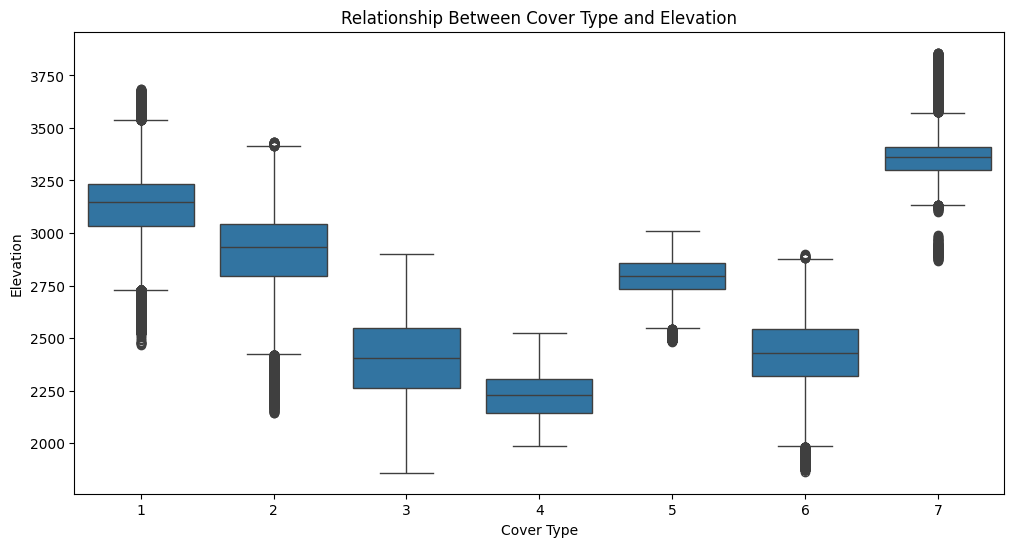

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cover_Type", y="Elevation", data=df_pandas)
plt.title("Relationship Between Cover Type and Elevation")
plt.xlabel("Cover Type")
plt.ylabel("Elevation")
plt.show()

<ipython-input-46-cd6cbf02f6df>:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="Cover_Type", y="Elevation", data=df_pandas, scale="width")


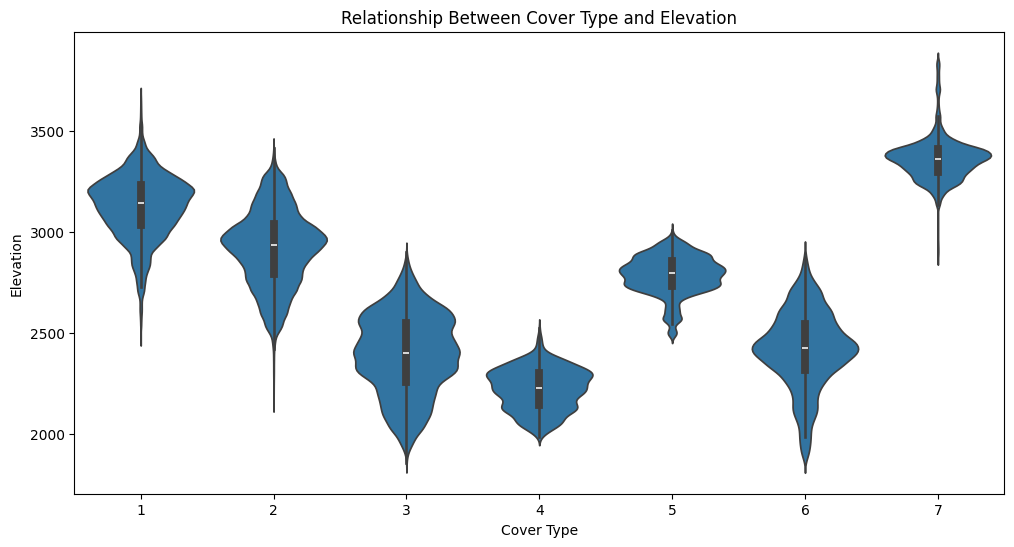

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(x="Cover_Type", y="Elevation", data=df_pandas, scale="width")
plt.title("Relationship Between Cover Type and Elevation")
plt.xlabel("Cover Type")
plt.ylabel("Elevation")
plt.show()

## Histograms

## Pre processing

We change the target class `Cover_Type` in such way that the classes start from 0 up to 6.

In [10]:
df = df.withColumn("Cover_Type", df["Cover_Type"] - 1)
df.groupBy("Cover_Type").count().orderBy("Cover_Type").show()

+----------+------+
|Cover_Type| count|
+----------+------+
|         0|211840|
|         1|283301|
|         2| 35754|
|         3|  2747|
|         4|  9493|
|         5| 17367|
|         6| 20510|
+----------+------+



As seen in the Dataset Exploration section the dataset values have different scales and units of measurement. Many ML algorithms are sensitive to magnitude changes, so we want to scale the non binary features in order to be able to increase the performance at training time and the convergence of the model.

To do so we use `VectorAssembler`, a feature transformer that merges multiple columns into a vector column that we will use later to perform the scaling.


In [11]:
input_columns = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
                 "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
                 "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"]

In [12]:
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
df_assembled = assembler.transform(df)

In [13]:
df_assembled.select("features").show(5, truncate=False)

+---------------------------------------------------------------+
|features                                                       |
+---------------------------------------------------------------+
|[2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0]     |
|[2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0]    |
|[2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0]  |
|[2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0]|
|[2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0]    |
+---------------------------------------------------------------+
only showing top 5 rows



### Min Max Scaler

To scale the data we use the `MinMaxScaler`, wich rescale each feature into a predetermined range, in our case [0,1].

In [14]:
minmax_scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
minmax_model = minmax_scaler.fit(df_assembled)

In [15]:
df_mm_scaled = minmax_model.transform(df_assembled)
df_mm_scaled.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_

We can see that the values range from 0 to 1.

In [16]:
df_mm_scaled.select("scaled_features").show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                       |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.36868434217108553,0.14166666666666666,0.045454545454545456,0.18468146027201143,0.2235142118863049,0.07165940705353378,0.8700787401574803,0.9133858267716535,0.5826771653543307,0.875365955667085]  |
|[0.36568284142071034,0.15555555555555556,0.030303030303030304,0.15175375805297064,0.2157622739018088,0.054798370099761136,0.8661417322834646,0.9251968503937008,0.5944881889763779,0.86783772480133

At this point we reassemble the scaled features with the 40 one hot encoded Soil Type and the 4 Wilderness Area features with Vector Assembler

In [17]:
soil_cols = [col for col in df.columns if col.startswith("Soil_Type")]
wilderness_cols = [col for col in df.columns if col.startswith("Wilderness_Area")]

final_assembler = VectorAssembler(inputCols=["scaled_features"] + soil_cols + wilderness_cols,  #add soil_type + wilderness_area to the scaled_features
                                  outputCol="final_features")

df_mm_final = final_assembler.transform(df_mm_scaled)

In [18]:
df_mm_final.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fi


With Vector Assembler we can see how Spark uses *sparse representation* instead of dense to save memory since we have a lot of binary features. Instead of storing all the zeros, the sparse vector format only stores the positions and values of the non-zero elements, saving memory. This type of representation should also save speed and be more scalable.

In [19]:
df_mm_final.select("final_features").show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|final_features                                                                                                                                                                                                                                 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(54,[0,1,2,3,4,5,6,7,8,9,38,50],[0.36868434217108553,0.14166666666666666,0.045454545454545456,0.18468146027201143,0.2235142118863049,0.07165940705353378,0.8700787401574803,0.9133858267716535,0.5826771653543307,0.875365955667085,1.0,1.0])  |
|(54,[0,1,2,3,4,5,6,7,8,9,38,50]

## Evaluation

For the evaluation of the model we use the `MulticlassClassificationEvaluator` that is an evaluator specifically for multiclass classification tasks, where the true labels are compared against the predicted labels. We compute multiple metrics to better understand how good the model is training, in particular:

- Accuracy
- F1 Score
- Precision
- Recall


In [20]:
evaluator = MulticlassClassificationEvaluator(labelCol="Cover_Type", predictionCol="prediction")

We define the function `compute_metrics` that will be called later after the training of the models. These metrics can help us understand if there is the need to tweak the hyperparameters of the model to reach better results.

In [21]:
def compute_metrics(predictions):
    evaluator.setMetricName("accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"Test Accuracy = {accuracy:.2f}")

    evaluator.setMetricName("f1")
    f1_score = evaluator.evaluate(predictions)
    print(f"F1 Score = {f1_score:.2f}")

    evaluator.setMetricName("weightedPrecision")
    weighted_precision = evaluator.evaluate(predictions)
    print(f"Weighted Precision = {weighted_precision:.2f}")

    evaluator.setMetricName("weightedRecall")
    weighted_recall = evaluator.evaluate(predictions)
    print(f"Weighted Recall = {weighted_recall:.2f}")


## Train and Test Set

Here we proceed to split the dataframe in train set and test set.

In [22]:
(trainSplit_mm, testSplit_mm) = df_mm_final.randomSplit([0.7, 0.3], seed=42)

In [ ]:
num_rows = trainSplit_mm.count()
num_columns = len(trainSplit_mm.columns)
print(f"The train split has {num_rows} rows and {num_columns} columns.")

num_rows = testSplit_mm.count()
num_columns = len(testSplit_mm.columns)
print(f"The test split has {num_rows} rows and {num_columns} columns.")

The train split has 406644 rows and 58 columns.
The test split has 174368 rows and 58 columns.


In [ ]:
trainSplit_mm.show(5)
testSplit_mm.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fi

## Algorithms

In this project we can see the application of 3 Machine Learning **classification** algorithms. In particular:

*   Naive Bayes
*   Random Forest
*   Logistic Regression

### Naive Bayes

Naive Bayes is a probabilistic classification algorithm based on Bayes' Theorem. The key assumption of Naive Bayes is that the features are *conditionally independent* given the target class. This assumption is rarely true in real-world scenarios, but simplifies computation and can help reaching good results, particularly with high-dimensional data.

In this specific case, we see the `multinomial` variant of Naive Bayes, which is well-suited for multi-class classification problem with categorical outcomes.

The model also set the `smoothing parameter` to "1.0", which helps mitigate issues with assigning zero probabilities if a particular feature-value combination is absent in the training data, improving its generalization to unseen data.

In [ ]:
nb = NaiveBayes(labelCol="Cover_Type", \
                featuresCol="final_features", \
                modelType="multinomial", \
                smoothing=1.0)

In [ ]:
# fit and evaluate the model
nbModel = nb.fit(trainSplit_mm)
nbPred = nbModel.transform(testSplit_mm)

In [ ]:
compute_metrics(nbPred)

Test Accuracy = 0.64
F1 Score = 0.62
Weighted Precision = 0.63
Weighted Recall = 0.64


In [ ]:
nbPred.groupBy("prediction").count().orderBy(col("count").desc()).show()

+----------+------+
|prediction| count|
+----------+------+
|       1.0|108125|
|       0.0| 47143|
|       2.0| 18429|
|       6.0|   362|
|       5.0|   306|
|       3.0|     3|
+----------+------+



The Naive Bayes method does not achieve great results, the accuracy reach 64% of accuracy. This could be due to the fact that the dataset is highly imbalanced as seen in the Dataset Exploration section. By showing the predictions of the model we see that the fist 2 classes, the most numerous, are also those that contain the most predictions also at the expense of classes that have fewer instances.

We visualize the confusion matrix as a heatmap to assess how well the model performed by comparing the true labels (Cover_type) with the predicted labels.


The heatmap should helps us identify the model's strengths and weaknesses, such as which classes are accurately predicted and where misclassifications occur.

In [ ]:
nbPred_pandas = nbPred.select("Cover_type", "prediction").toPandas()

confusion_matrix = nbPred_pandas.groupby(["Cover_type", "prediction"]).size().reset_index(name="count")
heatmap_data = confusion_matrix.pivot(index="Cover_type", columns="prediction", values="count").fillna(0)

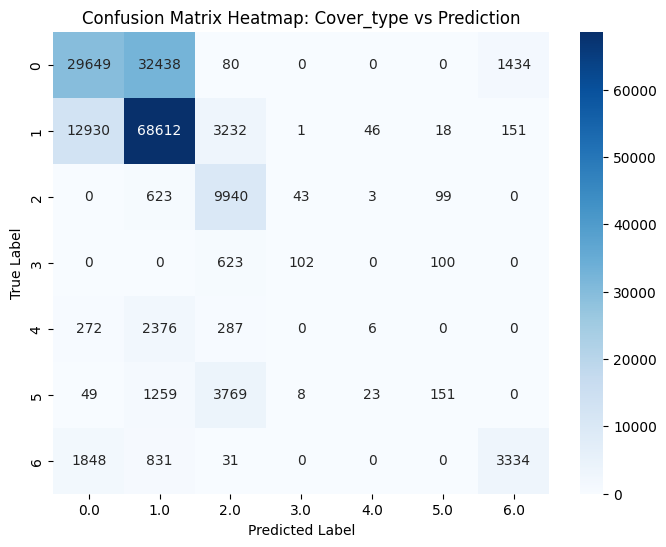

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Blues", cbar=True)
plt.title("Confusion Matrix Heatmap: Cover_type vs Prediction")
plt.xlabel("Predicted Labels")
plt.ylabel("True Label")
plt.show()

Further analysis might be conducted by balancing the dataset, either by undersampling the most numerous classes, by oversampling the less numerous classes, or by assigning weights to the classes (particularly high weights to the minority classes in order to counteract the imbalance).

### Random Forest

The Random Forest model is an *ensemble* learning method that combines the predictions of multiple decision trees to improve accuracy and reduce the risk of overfitting. Each tree in the forest is trained on a different subset of the data taken randomly from the train set. This technique is known as *bagging* (bootstrap aggregating). Moreover, at each split within the trees, only a random subset of features is considered, reducing the risk of overfitting and ensuring the model generalizes better to unseen data.

In the first implementation, we configure several hyperparameters to fine-tune the model. The `numTrees` parameter is set to "150", meaning the model will average the predictions from 150 decision trees to achieve a more robust and accurate prediction. The `maxDepth` of the trees is capped at "8", which should help maintaining computational efficiency. We also set `maxBins` to "25", which specifies the maximum number of bins used to discretize continuous features during tree splits.

In [26]:
# define rf model
rf_1 = RandomForestClassifier(labelCol="Cover_Type",
                              featuresCol="final_features",
                              numTrees=150,
                              maxDepth=8,
                              maxBins=25,
                              seed=42)

In [27]:
rfModel_1 = rf_1.fit(trainSplit_mm)
rfPred_1 = rfModel_1.transform(testSplit_mm)

In [25]:
compute_metrics(rfPred_1)

Test Accuracy = 0.71
F1 Score = 0.68
Weighted Precision = 0.68
Weighted Recall = 0.71


The test accuracy reach 71%, we keep tweaking the hyperparameters to see if we can reach a better result.

We raise the `maxDepth` value to "30". At the same time we lower the `numTrees` to "100" to lower the memory consumption and make computation more efficient.

We also set `featureSubsetStrategy` to "sqrt", meaning that a number of features equal to the square root of the total number of features in the dataset is selected at each split. This should help balancing between tree diversity and accuracy, and should reduces the risk of overfitting.

In [ ]:
rf_2 = RandomForestClassifier(labelCol="Cover_Type",
                              featuresCol="final_features",
                              numTrees=100,
                              maxDepth=30,
                              minInstancesPerNode=2,
                              featureSubsetStrategy="sqrt",
                              seed=42)

In [ ]:
# fit and evaluate the model
rfModel_2 = rf_2.fit(trainSplit_mm)
rfPred_2 = rfModel_2.transform(testSplit_mm)

In [ ]:
compute_metrics(rfPred_2)

Test Accuracy = 0.89
F1 Score = 0.88
Weighted Precision = 0.89
Weighted Recall = 0.89


By tweaking the Random Forest hyperparameters, the model's performance improved significantly, with a test accuracy of 89% and an F1 score of 88%.

Surely increasing the `maxDepth` to "30" allowed the trees to capture more complex patterns, and this coul have helped in having a higher accuracy.

In [ ]:
rfPred_2.groupBy("prediction").count().orderBy(col("count").desc()).show()

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0|91657|
|       0.0|60198|
|       2.0|11942|
|       6.0| 5165|
|       5.0| 3704|
|       4.0| 1063|
|       3.0|  639|
+----------+-----+



In [ ]:
rfPred_2_pandas = rfPred_2.select("Cover_type", "prediction").toPandas()

confusion_matrix = rfPred_2_pandas.groupby(["Cover_type", "prediction"]).size().reset_index(name="count")
heatmap_data = confusion_matrix.pivot(index="Cover_type", columns="prediction", values="count").fillna(0)

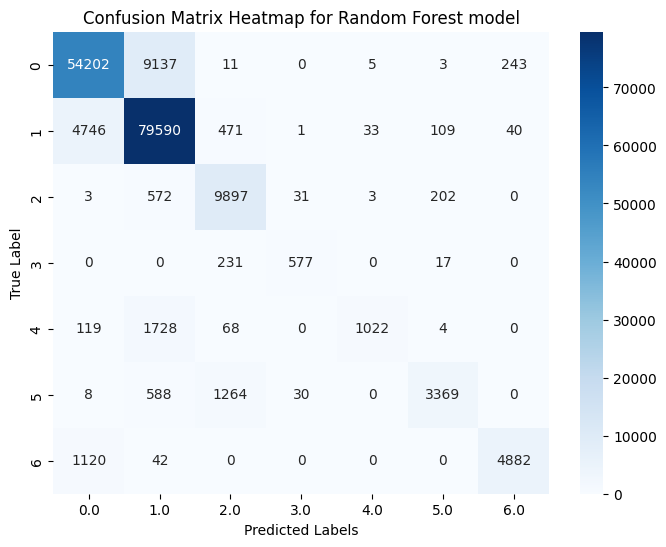

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Blues", cbar=True)
plt.title("Confusion Matrix Heatmap for Random Forest model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Label")
plt.show()

### Logistic regression

Logistic regression is a statistical model used for binary classification where the goal is to predict a category or class label. It's called logistic because it uses the logistic function (also known as the sigmoid function) to predict probabilities that map any real-valued number into a range between 0 and 1.

In PySpark it can be extended to handle multi-class classification problems through the One-vs-Rest technique. Specifically, a binary classifier is trained for each class, where each one of them distinguishes one class from all others.

In this model we specify `maxIter` equal to "500" so that the model tries to converge by iterating up to 500 times. We also set `family` to "multinomial" sine this is a multi class classification model.

In [57]:
lr = LogisticRegression(featuresCol="final_features",
                          labelCol="Cover_Type",
                          maxIter=500,
                          family="multinomial")

In [58]:
lrModel = lr.fit(trainSplit_mm)
lrPred = lrModel.transform(testSplit_mm)

In [59]:
compute_metrics(lrPred)

Test Accuracy = 0.72
F1 Score = 0.71
Weighted Precision = 0.71
Weighted Recall = 0.72


In [60]:
lrPred.groupBy("prediction").count().orderBy(col("count").desc()).show()

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0|91228|
|       0.0|62137|
|       2.0|12772|
|       6.0| 4806|
|       5.0| 2800|
|       3.0|  550|
|       4.0|   75|
+----------+-----+



In [61]:
lrPred_pandas = lrPred.select("Cover_type", "prediction").toPandas()

confusion_matrix = lrPred_pandas.groupby(["Cover_type", "prediction"]).size().reset_index(name="count")
heatmap_data = confusion_matrix.pivot(index="Cover_type", columns="prediction", values="count").fillna(0)

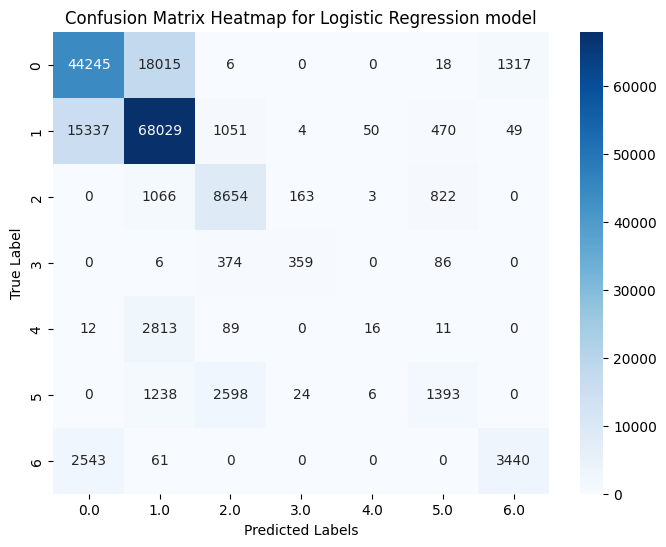

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Blues", cbar=True)
plt.title("Confusion Matrix Heatmap for Logistic Regression model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Label")
plt.show()

## Conclusion

The accuracy varies depending on the model we use. Not all of them manage to reach an accuraccy that we can consider satisfactory.

**Naive Bayes** reach an accuracy of **64%**, but as previously speculated, the results could be due to the large imbalance in the data.
**Logistic Regression** manage to reach only **72%** while **Random Forest** turn out to be the best model with an accuracy of **89%**, but only after setting the max depth of the trees up to 30, the maximum value we can set, having as downsides a very memory-intensive computations and a longer training time.

To further improve the results, several strategies could be considered, such as *oversampling*, *undersampling*, or *feature weighting*. Additionally, exploring *feature selection* versus *feature extraction* with PCA might prove beneficial. In the preprocessing stage, applying *StandardScaler* to normalize the data to zero mean and unit variance (mean = 0, standard deviation = 1) could be valuable for both Random Forest and Logistic Regression models. However, it is important to note that Naive Bayes cannot process negative input values, so this consideration would not apply in its case.